In [2]:
# Helper libraries
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

# Tensorflow and Scikit
from tensorflow import keras
from sklearn.model_selection import train_test_split
from sklearn import preprocessing


In [3]:
# Correlation-based Feature Selection: Feature Pairwise Comparison 

# Returns list of feature names to be dropped
def calcDrop(res):
    # All variables with correlation > cutoff
    all_corr_vars = list(set(res['v1'].tolist() + res['v2'].tolist()))
    
    # All unique variables in drop column
    poss_drop = list(set(res['drop'].tolist()))

    # Keep any variable not in drop column
    keep = list(set(all_corr_vars).difference(set(poss_drop)))
    
    # Drop any variables in same row as a keep variable
    p = res[ res['v1'].isin(keep)  | res['v2'].isin(keep) ][['v1', 'v2']]
    q = list(set(p['v1'].tolist() + p['v2'].tolist()))
    drop = (list(set(q).difference(set(keep))))

    # Remove drop variables from possible drop 
    poss_drop = list(set(poss_drop).difference(set(drop)))
    
    # subset res dataframe to include possible drop pairs
    m = res[ res['v1'].isin(poss_drop)  | res['v2'].isin(poss_drop) ][['v1', 'v2','drop']]
        
    # remove rows that are decided (drop), take set and add to drops
    more_drop = set(list(m[~m['v1'].isin(drop) & ~m['v2'].isin(drop)]['drop']))
    for item in more_drop:
        drop.concat(item)

    return drop

# Creates a correlation matrix
def corrX_new(df, cut = 0.9) :
    # Get correlation matrix and upper triagle
    corr_mtx = df.corr().abs()
    avg_corr = corr_mtx.mean(axis = 1)
    up = corr_mtx.where(np.triu(np.ones(corr_mtx.shape), k=1).astype(np.bool_))
    
    dropcols = list()
    
    res = pd.DataFrame(columns=(['v1', 'v2', 'v1.target', 
                                'v2.target','corr', 'drop' ]))
    
    for row in range(len(up)-1):
        col_idx = row + 1
        for col in range (col_idx, len(up)):
            if(corr_mtx.iloc[row, col] > cut):
                if(avg_corr.iloc[row] > avg_corr.iloc[col]): 
                    dropcols.append(row)
                    drop = corr_mtx.columns[row]
                else: 
                    dropcols.append(col)
                    drop = corr_mtx.columns[col]
                
                s = pd.Series([ corr_mtx.index[row],
                up.columns[col],
                avg_corr[row],
                avg_corr[col],
                up.iloc[row,col],
                drop],
                index = res.columns)
        
                res = res.append(s, ignore_index = True)
    
    dropcols_names = calcDrop(res)
    
    return(dropcols_names)

# Performs simple pairwise correlation using pearson coefficient and outputs the graph
def simple_corr(df):
    df_corr = df.corr()
    fig = plt.figure(figsize=(16,14))
    sns.heatmap(df_corr, annot=True, cmap=plt.cm.Reds)
    fig.savefig("output/corr_matrix.jpg")
    plt.show()

In [4]:
# Read dataset csv file
df = pd.read_csv('datasets\\peanut_mold_detection_watershed.csv')
df.sample(frac=1, random_state=42).reset_index(drop=True)

# Data Columns
info_col = ['sample_id', 'area']
features_col = ['red', 'green', 'blue', 'hue', 'sat', 'value', 'gray', 'contrast', 'dissimilarity', 'homogeneity', 'energy', 'correlation', 'asm']
target_col = ['class']

# Split features and class
sample_info = df[info_col]
X = df[features_col]
y = df[target_col]

max_f = X.shape[1]+1    # max features
test_size = 0.3         # test dataset size

In [6]:
# Normalize feature data
scaler = preprocessing.MinMaxScaler()
d = scaler.fit_transform(X)
SCALED_X = pd.DataFrame(d, columns=features_col)
SCALED_X.head()

,red,green,blue,hue,sat,value,gray,contrast,dissimilarity,homogeneity,energy,correlation,asm
0,0.665454,0.467331,0.143971,0.355984,0.865238,0.665244,0.485194,0.125244,0.116112,0.542372,0.286834,0.879719,0.174404
1,0.792649,0.584239,0.310303,0.359030,0.712812,0.792465,0.615305,0.211435,0.195039,0.530225,0.413116,0.884903,0.279861
2,0.760230,0.574285,0.278962,0.364585,0.740217,0.760057,0.595725,0.155582,0.262068,0.385167,0.404129,0.919319,0.271776
3,0.752523,0.600287,0.384692,0.258084,0.615565,0.752291,0.624045,0.213800,0.233776,0.469578,0.411608,0.883392,0.278498
4,0.689456,0.551259,0.339850,0.281672,0.636426,0.689223,0.570399,0.098627,0.123600,0.664742,0.590508,0.992561,0.457606


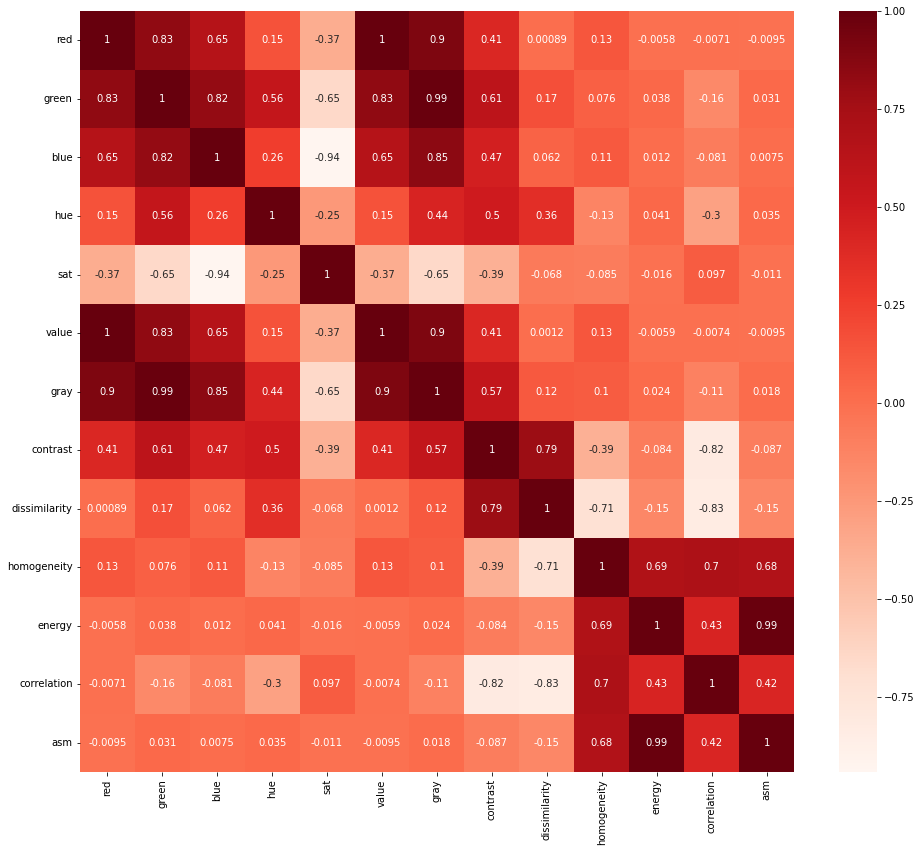

In [7]:
simple_corr(SCALED_X)

In [9]:
cutoff = 0.95
features_to_drop = corrX_new(SCALED_X, cut=cutoff)
print(features_to_drop)

C:\Users\SAMUEL~1\AppData\Local\Temp/ipykernel_18308/3533869757.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(s, ignore_index = True)
C:\Users\SAMUEL~1\AppData\Local\Temp/ipykernel_18308/3533869757.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(s, ignore_index = True)
C:\Users\SAMUEL~1\AppData\Local\Temp/ipykernel_18308/3533869757.py:63: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  res = res.append(s, ignore_index = True)


['green', 'value', 'energy']


In [10]:
# DO NOT RUN IF YOU DO NOT WANT TO REMOVE ANY FEATURES
SCALED_X.drop(features_to_drop, inplace=True, axis=1)

In [11]:
temp_dataset = pd.concat([sample_info, SCALED_X], axis=1)
# temp_dataset.head()

train_x, test_x, train_y, test_y = train_test_split(temp_dataset, y,
                                                            test_size=test_size,
                                                            random_state=42)

TRAIN_X_INFO = train_x.loc[:, info_col]
train_x.drop(info_col, inplace=True, axis=1)
TEST_X_INFO = test_x.loc[:, info_col]
test_x.drop(info_col, inplace=True, axis=1)

In [12]:
n_features = SCALED_X.shape[1]
h1_size = (n_features*2//3)+1
h2_size = (h1_size*2//3)+1
print("Total Feaures: {}".format(n_features))
print("Hidden Layer 1: {}".format(h1_size))
print("Hidden Layer 2: {}".format(h2_size))

Total Feaures: 10
Hidden Layer 1: 7
Hidden Layer 2: 5


In [13]:
# Build model architecture
train_model = keras.Sequential([
    keras.layers.Flatten(input_shape=(n_features, )),   # input layer
    keras.layers.Dense(h1_size, activation='tanh'),         # hidden layer 1
    keras.layers.Dense(h2_size, activation='tanh'),         # hidden layer 2
    keras.layers.Dense(1, activation='sigmoid')             # output layer
])

In [14]:
# Compile model
train_model.compile(optimizer='adam',
                    loss='binary_crossentropy',
                    metrics=[keras.metrics.BinaryAccuracy()])

In [15]:
# Train the model
interval = 1    # no. of times training will occur
epochs = 10     # no. of epochs per training interval
batch_size = train_x.shape[0]

# Record of training
training_loss = []
training_acc = []
testing_loss = []
testing_acc = []

for i in range(interval):
    history = train_model.fit(train_x, train_y, epochs=epochs, verbose=0, batch_size=batch_size)
    test_history = train_model.evaluate(test_x,  test_y, verbose=1)

    training_loss.append(history.history['loss'][epochs-1])
    training_acc.append(history.history['binary_accuracy'][epochs-1])

    testing_loss.append(test_history[0])
    testing_acc.append(test_history[1])



17/17 [==============================] - 0s 1ms/step - loss: 0.7229 - binary_accuracy: 0.5000


loss: 0.3628 - binary_accuracy: 0.8456 - epochs: 1700

In [16]:
# Record training and testing data to excel file
fields = ['Training Loss', 'Training Accuracy', 'Testing Loss', 'Testing Accuracy']
f_data = {'Training Loss': training_loss, 'Training Accuracy': training_acc, 'Testing Loss': testing_loss, 'Testing Accuracy': testing_acc}
results = pd.DataFrame(data=f_data, columns=fields)
results.to_excel('output\\results_model_1.xlsx', index=False)


In [17]:
# Save prediction model
MODEL_PATH = "models\\model_1"
train_model.save(MODEL_PATH)

INFO:tensorflow:Assets written to: models\model_1\assets


In [29]:
# Test on test dataset
predict_test = train_model.predict(test_x)

for i in range(test_y.shape[0]):
    sample_name = TEST_X_INFO.iloc[i]['sample_id']
    print("Examining: {}".format(sample_name))
    actual = test_y.iloc[i][0]
    pred = predict_test[i][0]
    print("Actual: {} | Predict: {}".format(actual, pred))
    err_diff = abs(actual-pred)
    print("Error: {}".format(err_diff*100))
    if err_diff < 0.5:
        print("Correct!")
    else:
        print("Incorrect!")


Examining: samples\Non-Contaminated\Output_Watershed\Test_batch_2_002_015.jpg
Actual: 0 | Predict: 0.5849143862724304
Error: 58.49143862724304
Incorrect!
Examining: samples\Contaminated\Output_Watershed\Test_batch_3_001_035.jpg
Actual: 1 | Predict: 0.5897378325462341
Error: 41.02621674537659
Correct!
Examining: samples\Non-Contaminated\Output_Watershed\Test_batch_3_002_027.jpg
Actual: 0 | Predict: 0.652288556098938
Error: 65.2288556098938
Incorrect!
Examining: samples\Contaminated\Output_Watershed\Test_batch_4_005_022.jpg
Actual: 1 | Predict: 0.6173304915428162
Error: 38.266950845718384
Correct!
Examining: samples\Non-Contaminated\Output_Watershed\Test_batch_3_003_023.jpg
Actual: 0 | Predict: 0.6356320977210999
Error: 63.563209772109985
Incorrect!
Examining: samples\Contaminated\Output_Watershed\Test_batch_7_003_014.jpg
Actual: 1 | Predict: 0.6298754811286926
Error: 37.01245188713074
Correct!
Examining: samples\Non-Contaminated\Output_Watershed\Test_batch_2_004_030.jpg
Actual: 0 | Pred